In [38]:
import pandas as pd
from pandas import Series, DataFrame
import codecs

In [39]:
#Video_idの被りを省く
with codecs.open("JPvideos.csv", "r", "UTF-8", "ignore") as file:
    df =  pd.read_csv(file)
    df.drop_duplicates(subset='video_id', keep='last', inplace=True)

In [40]:
#必要のないと思われるCategoryID
remove_CategoryID = [3,4,5,6,7,8,9,11,12,13,14,16,28]
for n in remove_CategoryID:
    df = df[df["category_id"]!=n]

In [41]:
#再生数が50万を超えている動画のみ
df = df[df["views"]>500000]

In [5]:
#[]が含まれるなら1,含まれないなら0

buzz_word_Braces = ["【","】",]
for i in buzz_word_Braces:
    df.loc[df['title'].str.contains(i),"title_encode_Braces"] = 1
df.loc[df['title_encode_Braces'].isnull(),"title_encode_Braces"] = 0

In [6]:
#バズりやすい言葉があれば1,それ以外を0

buzz_word = ["神回","悲報","www","衝撃","危険","危機"]
for n in buzz_word:
    df.loc[df['title'].str.contains(n),"title_encode_word"] = 1
df.loc[df['title_encode_word'].isnull(),"title_encode_word"] = 0

In [7]:
#メッセージの長さ
df['len_title'] = df['title'].apply(lambda x: len(str(x).replace(' ', '')))
df["len_title"].describe()

count    1083.000000
mean       41.727608
std        19.195382
min         3.000000
25%        27.000000
50%        38.000000
75%        55.000000
max        97.000000
Name: len_title, dtype: float64

In [8]:
df.loc[df['len_title'] > 45,"title_encode_len"] = 2
df.loc[df['len_title'] < 45 ,"title_encode_len"] = 1
df.loc[df['len_title'] < 24,"title_encode_len"] = 0

In [9]:
#100万再生なら1,違うなら0とする
df.loc[df['views'] > 1000000,"view_encode"] = 1
df.loc[df['view_encode'].isnull(),"view_encode"] = 0

In [10]:
#データフレームを整える
df2 = df[['title_encode_Braces','title_encode_word','title_encode_len']]
df2 = df2.fillna(0)

In [11]:
#データの可視化
df_ex = df[['title_encode_Braces','title_encode_word','title_encode_len','view_encode']]
df_ex = df_ex.fillna(0)
df_ex.describe()

,title_encode_Braces,title_encode_word,title_encode_len,view_encode
count,1083.000000,1083.000000,1083.000000,1083.000000
mean,0.192059,0.019391,1.204986,0.496768
std,0.394101,0.137957,0.708082,0.500221
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,2.000000,1.000000
max,1.000000,1.000000,2.000000,1.000000


In [12]:
#モデルの構築
import numpy as np
import numpy.random as random
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = df2
Y = df['view_encode']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
y_train.head()

3392     0.0
16303    1.0
15306    1.0
5597     1.0
14476    1.0
Name: view_encode, dtype: float64

In [13]:
#決定木

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# 決定木インスタンス(木の深さ3)
model = DecisionTreeClassifier(max_depth=5)
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)
predicted = model.predict(X_test)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.5689655172413793
test score: 0.5166051660516605


In [14]:
#混同行列の作成
plot_cm = confusion_matrix(predicted,y_test)
plot_cm

array([[46, 42],
       [89, 94]])

In [57]:
#グラフ表示に必要なモジュールのインストール
!pip install graphviz
!pip install seaborn

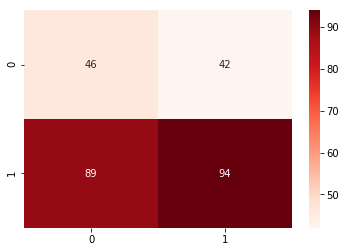

In [17]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(plot_cm, annot=True, cmap='Reds')

In [18]:
#決定木の出力
with open('YouTube-dtree.dot', mode='w') as f:
    tree.export_graphviz(model, out_file=f)

In [25]:
!dot -T png YouTube-dtree.dot -o YouTube-dtree.png
!open YouTube-dtree.png

In [20]:
cnt_ytrain = (y_train == 0)
cnt_ytrain.sum()

410

In [21]:
!pip install janome

In [22]:
#形態素解析の演習
from janome.tokenizer import Tokenizer
import collections

t_test = []
t = Tokenizer()
s = 'すもももももももものうち'
for token in t.tokenize(s):
    t_test.append((token.surface))
c = collections.Counter(t_test)
print(c)
#100万再生のデータフレームの生成
df_OneMillion = df[df["views"]>1000000]

Counter({'も': 2, 'もも': 2, 'すもも': 1, 'の': 1, 'うち': 1})


In [23]:
#形態素解析の適応

list_tword = []
for i in range(len(df_OneMillion)):
    title = df_OneMillion.iloc[i,2]
    for token in t.tokenize(title):
        list_tword.append((token.surface))
        c = collections.Counter(list_tword)
print(c)

Counter({' ': 3466, '-': 216, 'の': 115, '(': 114, '/': 113, '|': 101, '2018': 100, ')': 99, '】': 80, '【': 77, '！': 69, 'vs': 66, ',': 64, "'": 63, ':': 60, '.': 59, 'Game': 56, 'に': 56, 'Highlights': 54, 'Full': 52, 'が': 50, '2': 49, 'Official': 49, 'で': 49, 'た': 41, '1': 39, 'て': 35, 'The': 34, 'NBA': 33, '3': 33, 'を': 31, 'Trailer': 30, 'HD': 29, '&': 28, 'Video': 28, '$': 27, 'し': 25, '[': 24, '!': 23, ']': 23, '「': 21, '山口': 21, 'All': 20, '」': 20, 'は': 20, '、': 20, '？': 19, '  ': 19, 'M': 19, 'EP': 19, '・': 18, 'と': 18, 'Playoffs': 18, '18': 17, 'Cleveland': 17, 'Cavaliers': 17, 'たら': 17, 'Music': 17, '\u3000': 17, '゙': 17, 'is': 16, '。': 16, 'TOKIO': 16, '6': 15, 'Goals': 15, 'with': 15, 'TWICE': 15, 'MV': 15, 'Love': 15, 'BTS': 15, '?': 14, '5': 13, '0': 13, 's': 13, 'V': 13, '達也': 13, 'Trump': 12, '7': 12, 'Teaser': 12, 'ない': 12, 'the': 12, '人': 12, 'YOU': 12, 'To': 12, 'What': 12, 'Warriors': 11, 'Season': 11, '4': 11, 'One': 11, 'Last': 11, 'Week': 11, 'Tonight': 11, 'John': 

In [42]:
#再生数が50万を超えている動画のみ
dfprocessing = df[df["views"]>500000]

In [64]:
#該当した記号があるなら1,ないなら0とする

buzz_word_Symbol = ["【","】"]
for i in buzz_word_Symbol:
    dfprocessing.loc[dfprocessing['title'].str.contains(i),"title_encode_Symbol"] = 1
dfprocessing.loc[dfprocessing['title_encode_Symbol'].isnull(),"title_encode_Symbol"] = 0

In [65]:
#バズりやすい言葉があれば1,それ以外を0

buzz_word = ["2018","Game","vs","Highlights","Official","HD","Video","山口","All","TOKIO"]
for n in buzz_word:
    dfprocessing.loc[dfprocessing['title'].str.contains(n),"title_encode_word"] = 1
dfprocessing.loc[dfprocessing['title_encode_word'].isnull(),"title_encode_word"] = 0

In [66]:
#メッセージの長さ
dfprocessing['len_title'] = dfprocessing['title'].apply(lambda x: len(str(x).replace(' ', '')))
dfprocessing["len_title"].describe()

count    1083.000000
mean       41.727608
std        19.195382
min         3.000000
25%        27.000000
50%        38.000000
75%        55.000000
max        97.000000
Name: len_title, dtype: float64

In [67]:
dfprocessing.loc[dfprocessing['len_title'] > 45,"title_encode_len"] = 2
dfprocessing.loc[dfprocessing['len_title'] < 45 ,"title_encode_len"] = 1
dfprocessing.loc[dfprocessing['len_title'] < 24,"title_encode_len"] = 0

In [68]:
#100万再生なら1,違うなら0とする
dfprocessing.loc[dfprocessing['views'] > 1000000,"view_encode"] = 1
dfprocessing.loc[dfprocessing['view_encode'].isnull(),"view_encode"] = 0

In [69]:
dfprocessing2 = dfprocessing[['title_encode_Symbol','title_encode_word','title_encode_len']]
dfprocessing2 = dfprocessing2.fillna(0)

In [70]:
#モデルの構築
import numpy as np
import numpy.random as random
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = dfprocessing2
Y = dfprocessing['view_encode']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [71]:
#決定木

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# 決定木インスタンス(木の深さ3)
model = DecisionTreeClassifier(max_depth=5)
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)
predicted = model.predict(X_test)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.5714285714285714
test score: 0.5350553505535055


In [72]:
#混同行列の作成
plot_cm = confusion_matrix(predicted,y_test)
plot_cm

array([[60, 51],
       [75, 85]])

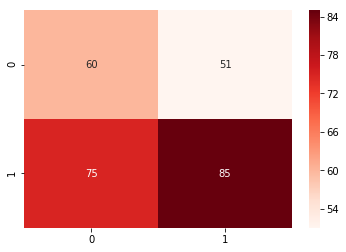

In [73]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(plot_cm, annot=True, cmap='Reds')

In [74]:
#決定木の出力
with open('YouTube-dtree2.dot', mode='w') as f:
    tree.export_graphviz(model, out_file=f)

In [75]:
!dot -T png YouTube-dtree2.dot -o YouTube-dtree2.png
!open YouTube-dtree2.png

In [76]:
# サポートベクターマシン（SVM）
from sklearn.svm import LinearSVC

# SVMインスタンス
model = LinearSVC()
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.5529556650246306
test score: 0.5313653136531366
